<a href="https://colab.research.google.com/github/Yan-Weijia/CompLing/blob/master/HW06/HW06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) 用 Word2vec 模型（自己训练的和rusvectores的）向量化文本，根据重述定义在所得向量上训练2个模型，找到最好的模型。

Обучите 2 модели по определению перефразирования на получившихся векторах Word2Vec要在另外的库训练（不在平行句子上），可以选用课堂上的数据或其它的

要用cross-validation评价模型，кросс-валидации! Метрика - f1

2) 分别用5种方法训练成对的文本向量：SVD, NMF, Word2Vec (自己的和rucvectores的), Fastext. 数据库的每行应有五对向量。在每对向量之间计算余弦相似度（一对5个）

通过这些相似度建立训练样本。在此样本上训练任何一个模型（Logreg，Random Forest或其他）， 并评估cross-validation(交叉验证)的质量（使用micro-f1-measure）。 尝试通过更改向量化时的参数来改进指标。

SVD 和 NMF 直接应用于数据, w2w 和 fastext 在其他库训练（与第一问一样）

Оценивание - если вы сделали всё вышеперечисленное - 10 баллов. Каждая ошибка - минус 0.5 балла.

Выложите код к себе на гитхаб и вставьте ссылку в поле ниже (в тетрадке должны быть показатели метрик и ваши комментарии).

In [0]:
!pip install pymorphy2
import nltk
nltk.download("stopwords")
import pandas as pd
from lxml import html
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
import gensim
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter,defaultdict
from string import punctuation
import os
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
%matplotlib inline

morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

def normalize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.parse(word)[0].normal_form for word in words if word and word not in stops]

    return ' '.join(words)

def tokenize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]

    return ' '.join(words)

In [0]:
!wget https://github.com/Yan-Weijia/CompLing/raw/master/HW06/corpus_hum.zip

In [0]:
!apt-get --yes install git

In [0]:
import zipfile
zFile = zipfile.ZipFile("corpus_hum.zip", "r")
for fileM in zFile.namelist(): 
  zFile.extract(fileM)
zFile.close()

In [11]:
rm corpus_hum.zip

corpus_hum.txt  corpus_hum.zip  sample_data/


In [0]:
data = open('corpus_hum.txt').read().splitlines()

data_norm = [normalize(text) for text in data] 
data_norm = [text for text in data_norm if text]

In [13]:
data_norm[:5]

['абай василий васо иван 1900–2001 русский лингвист родиться 2 15 декабрь 1900 с.коби тифлисский губерния ныне грузия 1925 окончить факультет общественный наука ленинградский университет 1928 аспирантура 1928–1930 сотрудник кавказский историко-археологический институт ан ссср 1930 полвека работать яфетический институт затем институт язык мышление институт языкознание ан ссср ленинград 1950 москва доктор филологический наука 1962 профессор 1969 лауреат государственный премия ссср 1981 почётный член азиатский королевский общество великобритания ирландия 1966 член-корреспондент финно-угорский общество хельсинки 1973 умереть абай москва 18 март 2001',
 'также тема',
 'лингвистика языкознание языковедение',
 'ученик н.я.марра ранний работа находиться влияние идея который впоследствии отойти видный специалист история иранский язык свой родной осетинский язык автор фундаментальный историко-этимологический словарь осетинский язык 5-ти том 1958–1990 заниматься также мифология фольклор иранский 

In [14]:
len(data_norm)

115082

## 矩阵分解

In [0]:
cv = CountVectorizer(min_df=3, max_df=0.4, max_features=1000)
X = cv.fit_transform(data_norm)

In [16]:
X.shape

(115082, 1000)

In [0]:
# svd = TruncatedSVD(2)
# svd.fit(X)

维度>2

In [0]:
svd4 = TruncatedSVD(4)
svd4.fit(X)
tsne = TSNE(2).fit_transform(svd4.components_.T)

In [0]:
id2word = {i:w for i,w in enumerate(cv.get_feature_names())}
word2id = {w:i for i,w in id2word.items()}

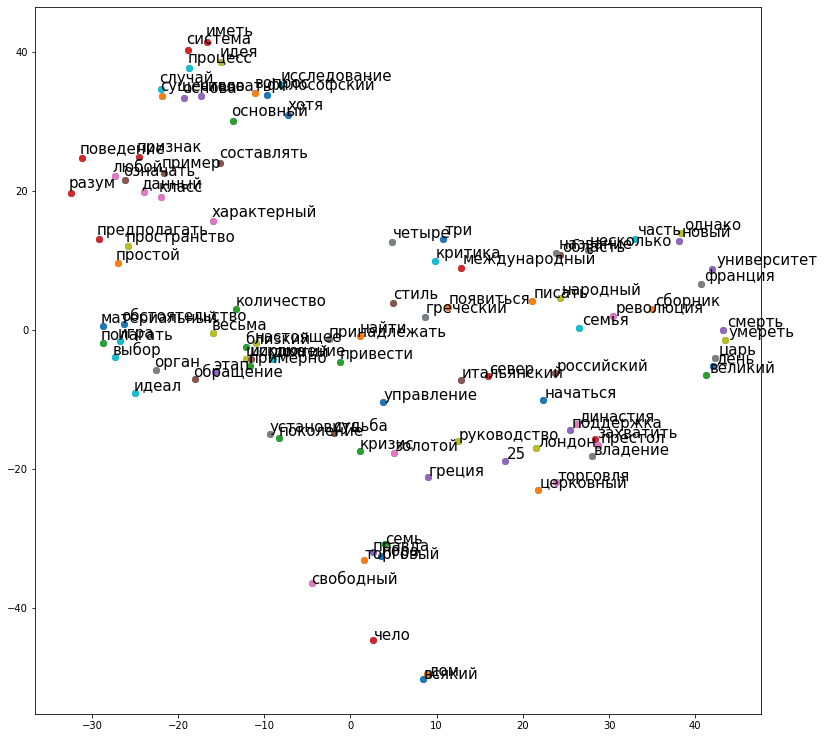

In [20]:
random_inds = np.random.choice(range(len(id2word)), 100, replace=False) 
# res = svd.components_.T[random_inds] # закомментируйте эту ячейку для TSNE
res = tsne[random_inds] # а эту наоборот раскомментируйте

plt.figure(figsize=(13,13))
plt.scatter(res[:,0], res[:,1])
for i, coor in enumerate(random_inds):
    x, y = res[i, 0], res[i, 1]
    plt.scatter(x, y)
    
    plt.annotate(id2word[coor], xy=(x, y), xytext=(x*1.01, y*1.01), textcoords='data',
                   ha='left', va='bottom', fontsize=15)

In [21]:
nmf = NMF(50)
nmf.fit(X)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=50, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [22]:
svd = TruncatedSVD(50)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0)

In [0]:
id2vec_svd = nmf.components_.T

In [0]:
id2vec_nmf = svd.components_.T

In [0]:
def most_similar(word, id2vec):
    similar = [id2word[i] for i in cosine_distances(id2vec[word2id[word]].reshape(1, -1), id2vec).argsort()[0][:10]]
    return similar

In [28]:
most_similar('четыре', id2vec_svd)

['четыре',
 'шесть',
 'три',
 'пять',
 'состоять',
 'первое',
 'будда',
 'назвать',
 'составлять',
 'себя']

In [38]:
most_similar('четыре', id2vec_nmf)

['четыре',
 'шесть',
 'три',
 'пять',
 'состоять',
 'первое',
 'будда',
 'семь',
 'себя',
 'согласно']

In [29]:
most_similar('юг', id2vec_svd)

['юг',
 'север',
 'район',
 'тысяча',
 'берег',
 'южный',
 'северный',
 'юго',
 'западный',
 'восточный']

In [39]:
most_similar('юг', id2vec_nmf)

['юг',
 'север',
 'южный',
 'северный',
 'берег',
 'юго',
 'район',
 'северо',
 'восточный',
 'восток']

In [30]:
most_similar('философия', id2vec_svd)

['философия',
 'философский',
 'логика',
 'идея',
 'мысль',
 'философ',
 'мышление',
 'религия',
 'la',
 'познание']

In [40]:
most_similar('философия', id2vec_nmf)

['философия',
 'философский',
 'философ',
 'мысль',
 'логика',
 'религия',
 'мышление',
 'античный',
 'религиозный',
 'существенный']

聚类

In [0]:
cluster_svd = MiniBatchKMeans(30, n_init=3, verbose=1, max_no_improvement=100, reassignment_ratio=0.4)
cluster_svd.fit(svd.components_.T)

In [0]:
cls_svd = defaultdict(list)

for i, cl in enumerate(cluster_svd.labels_):
    cls_svd[cl].append(id2word[i])

f = open('cluster_svd.txt', 'w')
for cl in cls_svd:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls_svd[cl]))
    f.write('\n\n')
f.close()

In [0]:
cluster_nmf = MiniBatchKMeans(40, n_init=3, verbose=1, max_no_improvement=100, reassignment_ratio=0.5)
cluster_nmf.fit(nmf.components_.T)

In [0]:
cls_nmf = defaultdict(list)

for i, cl in enumerate(cluster_nmf.labels_):
    cls_nmf[cl].append(id2word[i])
# откройте в любом текстовом редакторе
f = open('cluster_nmf.txt', 'w')
for cl in cls_nmf:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls_nmf[cl]))
    f.write('\n\n')
f.close()

In [37]:
ls

cluster_nmf.txt  cluster_svd.txt  corpus_hum.txt  corpus_hum.zip  sample_data/


## W2V, FastText

In [0]:
fast_text = gensim.models.FastText([text.split() for text in data_norm], size=50, 
                                   min_n=4, max_n=8) 
w2v = gensim.models.Word2Vec([text.split() for text in data_norm], size=50, sg=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


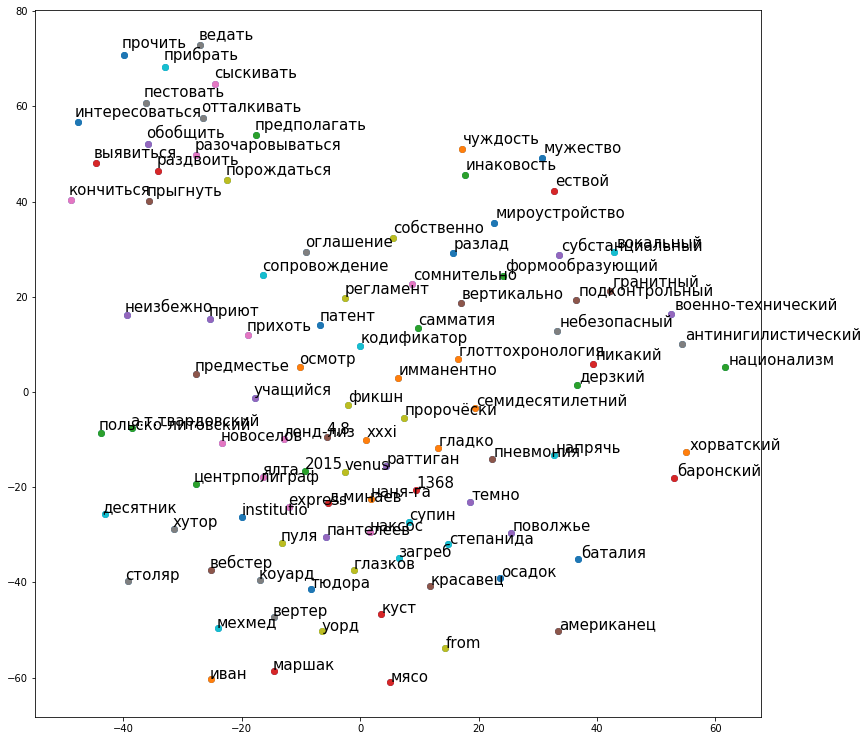

In [51]:
random_words = np.random.choice(fast_text.wv.index2word, 100, replace=False)
res = fast_text[random_words]
res = TSNE(2).fit_transform(res)

plt.figure(figsize=(13,13))
plt.scatter(res[:,0], res[:,1])
for i, coor in enumerate(res):
    x, y = coor
    plt.scatter(x, y)
    
    plt.annotate(random_words[i], xy=(x, y), xytext=(x*1.01, y*1.01), textcoords='data',
                   ha='left', va='bottom', fontsize=15)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


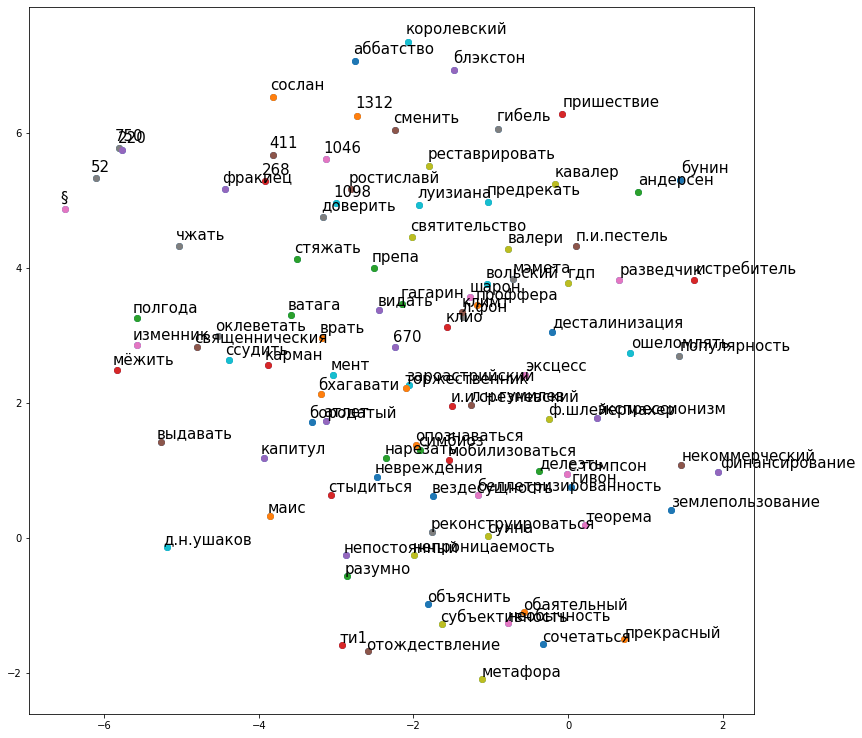

In [0]:
random_words = np.random.choice(w2v.wv.index2word, 100, replace=False)
res = w2v[random_words]
res = TSNE(2).fit_transform(res)

plt.figure(figsize=(13,13))
plt.scatter(res[:,0], res[:,1])
for i, coor in enumerate(res):
    x, y = coor
    plt.scatter(x, y)
    
    plt.annotate(random_words[i], xy=(x, y), xytext=(x*1.01, y*1.01), textcoords='data',
                   ha='left', va='bottom', fontsize=15)

In [43]:
fast_text.most_similar('язык')
# различия фастекста и ворд2века
# несуществующее слово (с опечаткой или с говорящей частью - "хренология" хороший пример)
# или попробуйте ввести слово с характерной составляющей (суффиксом прошедшего времени, приставкой пере)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('н.м.язык', 0.9936662316322327),
 ('праязык', 0.9440783858299255),
 ('подъязык', 0.920811116695404),
 ('язык-предок', 0.881205141544342),
 ('языкова', 0.8578133583068848),
 ('метаязык', 0.8422280550003052),
 ('язык-цель', 0.8345003724098206),
 ('протоязык', 0.8072965145111084),
 ('языковед', 0.7806494235992432),
 ('диалектолог', 0.7422525882720947)]

In [44]:
w2v.most_similar('язык')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('древнееврейский', 0.8049083352088928),
 ('иврит', 0.8009693026542664),
 ('латынь', 0.7974122762680054),
 ('фарси', 0.7952657341957092),
 ('идиш', 0.7949487566947937),
 ('церковно-славянский', 0.7876673340797424),
 ('осетинский', 0.7598540186882019),
 ('thesaurus', 0.7589524984359741),
 ('фольклор', 0.7515398263931274),
 ('подлинник', 0.7505515217781067)]

In [45]:
fast_text.most_similar("хренология")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('этнология', 0.9638876914978027),
 ('феноменология', 0.9627081751823425),
 ('синология', 0.9593952894210815),
 ('метеорология', 0.9551721811294556),
 ('неврология', 0.9490560293197632),
 ('египтология', 0.9471192955970764),
 ('невропатология', 0.947108268737793),
 ('астрология', 0.9467504620552063),
 ('педология', 0.94673091173172),
 ('тавтология', 0.9464685916900635)]

In [46]:
w2v.most_similar("хренология")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


KeyError: ignored

聚类

In [47]:
vocab = fast_text.wv.index2word
matrix = np.zeros((len(vocab), 50))

for i, word in enumerate(vocab):
    if word in vocab:
        matrix[i] = fast_text[word]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [0]:
cluster = MiniBatchKMeans(1000, n_init=2, verbose=1, max_no_improvement=300, reassignment_ratio=0.4)
cluster.fit(matrix)
cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(vocab[i])

f = open('cluster_ft.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

In [49]:
vocab_w2v = w2v.wv.index2word
matrix_w2v = np.zeros((len(vocab_w2v), 50))

for i, word in enumerate(vocab_w2v):
    if word in vocab_w2v:
        matrix_w2v[i] = fast_text[word]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [0]:
cluster_w2v = MiniBatchKMeans(1000, n_init=2, verbose=1, max_no_improvement=300, reassignment_ratio=0.4)
cluster_w2v.fit(matrix_w2v)
cls_w2v = defaultdict(list)

for i, cl in enumerate(cluster_w2v.labels_):
    cls_w2v[cl].append(vocab_w2v[i])

f = open('cluster_w2v.txt', 'w')
for cl in cls_w2v:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls_w2v[cl]))
    f.write('\n\n')
f.close()

FastText有考虑ngram，可直接输入非规范化文本

In [0]:
corpus = [tokenize(text).split() for text in data]
corpus = list(filter(bool, corpus))
fast_text = gensim.models.FastText(corpus, size=50)

In [53]:
vocab = fast_text.wv.index2word
matrix = np.zeros((len(vocab), 50))

for i, word in enumerate(vocab):
    if word in vocab:
        matrix[i] = fast_text[word]
        
cluster = MiniBatchKMeans(1000, n_init=2, verbose=1, max_no_improvement=300, reassignment_ratio=0.4)
cluster.fit(matrix)
cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(vocab[i])

f = open('cluster_ft.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Init 1/2 with method: k-means++


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


Inertia for init 1/2: 2019.786010
Init 2/2 with method: k-means++


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


Inertia for init 2/2: 2111.314720
Minibatch iteration 1/88000: mean batch inertia: 32.443593, ewa inertia: 32.443593 
Minibatch iteration 2/88000: mean batch inertia: 41.438848, ewa inertia: 32.464039 
Minibatch iteration 3/88000: mean batch inertia: 36.722218, ewa inertia: 32.473718 
Minibatch iteration 4/88000: mean batch inertia: 36.697793, ewa inertia: 32.483319 
Minibatch iteration 5/88000: mean batch inertia: 41.595543, ewa inertia: 32.504030 
Minibatch iteration 6/88000: mean batch inertia: 29.086290, ewa inertia: 32.496262 
Minibatch iteration 7/88000: mean batch inertia: 34.470940, ewa inertia: 32.500750 
Minibatch iteration 8/88000: mean batch inertia: 29.193075, ewa inertia: 32.493232 
Minibatch iteration 9/88000: mean batch inertia: 36.441284, ewa inertia: 32.502206 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/88000: mean batch inertia: 29.274892, ewa inertia: 32.494870 
Minibatch iteration 11/88000: mean batch inertia: 32.052739, ewa inertia: 3

## paraphrase

In [0]:
data=pd.read_csv()

In [0]:
cosine_dis